<a href="https://colab.research.google.com/github/skytecat/CreditScoring/blob/main/credit_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Установка необходимых библиотек
!pip install catboost
# !pip install optuna

# Импорт библиотек
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif


# from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# import seaborn as sns

# import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


## Загрузка данных

In [2]:
# Загрузка данных
full_data = pd.read_csv("/content/drive/MyDrive/SHIFT_ML_2025_COMPETITION/shift_ml_2025_train.csv")

# Разделение на признаки и целевую переменную
X = full_data.drop(['итоговый_статус_займа'], axis=1)
y = full_data['итоговый_статус_займа']

## Первичный анализ

In [ ]:
X.head(5)

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,...,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,68355089,1235000.0,3 года,11.99,41014.0,В,В1,инженер,10+ лет,ИПОТЕКА,...,7.7,0.0,0.0,15700850.0,1973750.0,3965000.0,1233350.0,NaN,Нет,Наличные
1,68341763,1000000.0,5 лет,10.78,21633.0,Б,Б4,водитель грузовика,10+ лет,ИПОТЕКА,...,50.0,0.0,0.0,10920900.0,934800.0,310000.0,743850.0,NaN,Нет,Наличные
2,68426831,597500.0,3 года,13.44,20259.0,В,В3,ветеринарный техник,4 года,АРЕНДА,...,100.0,0.0,0.0,845000.0,639900.0,470000.0,200000.0,NaN,Нет,Наличные
3,68476668,1000000.0,3 года,9.17,31879.0,Б,Б2,вице-президент операций по набору персонала,10+ лет,ИПОТЕКА,...,100.0,0.0,0.0,19442600.0,5838100.0,1575000.0,2322600.0,NaN,Нет,Наличные
4,67275481,1000000.0,3 года,8.49,31563.0,Б,Б1,дорожному водителю,10+ лет,ИПОТЕКА,...,0.0,0.0,0.0,9669500.0,1396850.0,725000.0,1807200.0,NaN,Нет,Наличные


In [ ]:
# Столбцы в train
X.columns.to_list()

['id',
 'сумма_займа',
 'срок_займа',
 'процентная_ставка',
 'аннуитет',
 'рейтинг',
 'допрейтинг',
 'профессия_заемщика',
 'стаж',
 'владение_жильем',
 'годовой_доход',
 'подтвержден_ли_доход',
 'рейтинг_OCR',
 'платежный_график',
 'коэфф_акционных_зачислений_в_остатке',
 'цель_займа',
 'кол_во_субсидий_за_год',
 'индекс_проживания',
 'регион',
 'пдн',
 'пос_стоп_фактор',
 'юридический_статус',
 'кол-во_просрочек_за_два_года',
 'коэфф_невыплаченного_сумм_остатка',
 'коэфф_исходного_платежа',
 'дата_первого_займа',
 'нижний_порог_рейтинга_заемщика',
 'верхний_порог_рейтинга_заемщика',
 'кол-во_заявок_за_полгода',
 'кол-во_месяцев_с_последней_просрочки',
 'кол-во_месяцев_с_последнего_займа',
 'кол-во_открытых_счетов',
 'кол-во_записей_в_общедоступных_документах',
 'оборотный_баланс',
 'коэфф_загрузки_возобновляемого_счета',
 'кол-во_счетов',
 'первоначальный_статус_займа',
 'непогашенная_сумма_из_тела_займов',
 'сумма_выплат_по_просрочкам',
 'пени_за_дефолт',
 'дата_следующей_выплаты',


Признак **пени_за_дефолт** вызывает подозрение на утечку данных (**data leakage**).


Этот признак становится известен только после наступления события "дефолт", то есть использовать его для предсказания этого события - это нарушение причинно-следственной связи. Модель не должна знать "будущее". Его необходимо удалить из признаков, используемых для обучения модели

Также следует удалить признак **дата_следующей_выплаты**, так как он является потенциальной утечкой данных. Дата следующей выплаты содержит информацию о будущем поведении заемщика, что нарушает причинно-следственную связь в предсказательной модели

In [3]:
X = X.drop(['пени_за_дефолт', 'дата_следующей_выплаты'], axis=1)

In [13]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% данных для теста
    stratify=y,     # сохраняем пропорции классов
    random_state=42 # для воспроизводимости результатов
)

In [ ]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение целевой переменной в тренировочных данных:")
print(round(y_train.value_counts(normalize=True),2))
print(f"\nРаспределение целевой переменной в тестовых данных:")
print(round(y_test.value_counts(normalize=True),2))

Размер тренировочной выборки: (968623, 106)
Размер тестовой выборки: (242156, 106)

Распределение целевой переменной в тренировочных данных:
итоговый_статус_займа
0    0.8
1    0.2
Name: proportion, dtype: float64

Распределение целевой переменной в тестовых данных:
итоговый_статус_займа
0    0.8
1    0.2
Name: proportion, dtype: float64


In [ ]:
# Проверка на пересечение ID в тестовой и тренировочной выборке
overlap = len(set(X_train['id']) & set(X_test['id']))
print(f"Количество совпадающих ID: {overlap}")

Количество совпадающих ID: 0


Вывод: Количество совпадающих id между обучающей и тестовой выборками - 0. Это означает, что выборки независимы по идентификаторам заемщиков.


**Признак id необходимо удалить** из признаков, используемых для обучения модели, т.к. он не несет никакой информации о характеристиках заемщика, его поведении или рисках. Модель, обученная на старых id, не сможет использовать этот признак для предсказания. Это может привести к переобучению модели


In [14]:
X_train = X_train.drop('id', axis=1)

In [15]:
X_test = X_test.drop('id', axis=1)

In [ ]:
# Анализ типов данных признаков
print(X.dtypes.value_counts())

float64    83
object     18
int64       5
Name: count, dtype: int64


## Выбор метрики оценки качества модели
В задаче кредитного скоринга выбор правильной метрики критически важен для
обеспечения соответствия бизнес-целям и корректной оценки модели.
Общепринятой метрикой в такой задаче является ROC AUC


In [ ]:
# Объяснение выбора ROC AUC
target_distribution = y.value_counts(normalize=True)
print("""
=== Почему выбрана метрика ROC AUC? ===

1. ФОКУС НА РАНЖИРОВАНИИ:
   - Нам важнее правильно упорядочить клиентов по уровню риска
   - ROC AUC измеряет способность модели отделять классы, а не точные вероятности

2. УСТОЙЧИВОСТЬ К ДИСБАЛАНСУ:
   - Дефолтных клиентов ~{:.1%}, надежных ~{:.1%}
   - ROC AUC не зависит от порога классификации
   - Accuracy в данном случае обманчива (даже случайная модель даст ~{:.1%} accuracy)

3. БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
   - AUC = 0.8 означает: вероятность 80%, что модель
     правильно ранжирует случайную пару (дефолтный, надежный) клиент
   - Это напрямую связано с бизнес-целью: минимизировать кредитные потери
""".format(target_distribution[0], target_distribution[1], target_distribution[0]))


=== Почему выбрана метрика ROC AUC? ===

1. ФОКУС НА РАНЖИРОВАНИИ:
   - Нам важнее правильно упорядочить клиентов по уровню риска
   - ROC AUC измеряет способность модели отделять классы, а не точные вероятности

2. УСТОЙЧИВОСТЬ К ДИСБАЛАНСУ:
   - Дефолтных клиентов ~80.0%, надежных ~20.0%
   - ROC AUC не зависит от порога классификации
   - Accuracy в данном случае обманчива (даже случайная модель даст ~80.0% accuracy)

3. БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
   - AUC = 0.8 означает: вероятность 80%, что модель 
     правильно ранжирует случайную пару (дефолтный, надежный) клиент
   - Это напрямую связано с бизнес-целью: минимизировать кредитные потери



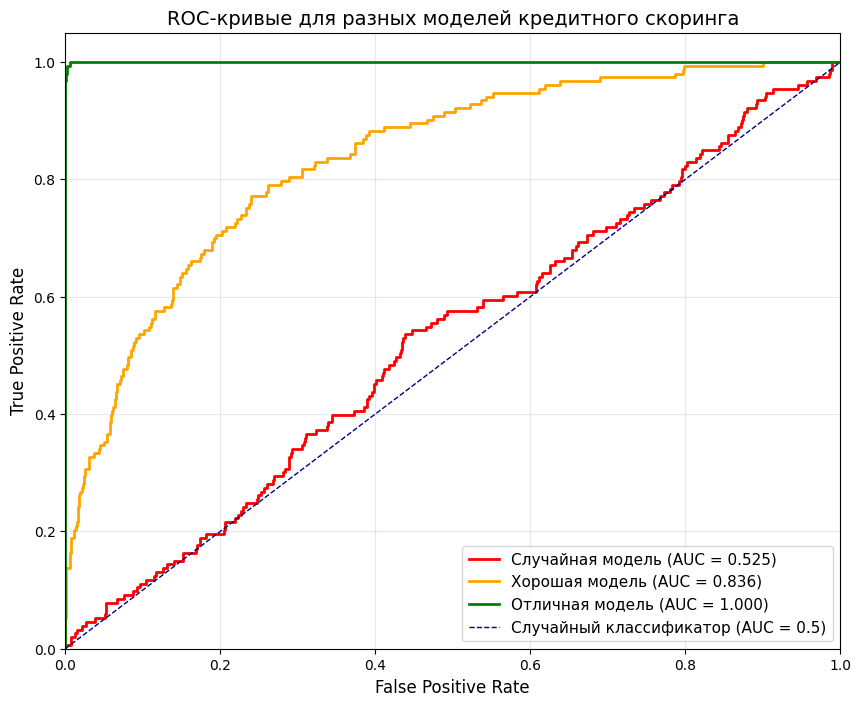

Результаты моделей:
Случайная модель: AUC = 0.525
Хорошая модель: AUC = 0.836
Отличная модель: AUC = 1.000


In [ ]:
# Визуализация ROC кривых

# Создаем синтетические данные для демонстрации
np.random.seed(42)
n_samples = 1000
y_test = np.random.binomial(1, 0.15, n_samples)  # 15% дефолтов

# Три модели для сравнения:
# 1. Случайная модель
y_pred_random = np.random.uniform(0, 1, n_samples)
fpr_random, tpr_random, _ = roc_curve(y_test, y_pred_random)
auc_random = auc(fpr_random, tpr_random)

# 2. Хорошая модель
y_pred_good = np.where(y_test == 1,
                       np.random.beta(2, 1, n_samples),  # Высокие вероятности для дефолтов
                       np.random.beta(1, 2, n_samples))  # Низкие вероятности для надежных
fpr_good, tpr_good, _ = roc_curve(y_test, y_pred_good)
auc_good = auc(fpr_good, tpr_good)

# 3. Отличная модель
y_pred_excellent = np.where(y_test == 1,
                           np.random.beta(8, 1, n_samples),  # Очень высокие вероятности для дефолтов
                           np.random.beta(1, 8, n_samples))  # Очень низкие вероятности для надежных
fpr_excellent, tpr_excellent, _ = roc_curve(y_test, y_pred_excellent)
auc_excellent = auc(fpr_excellent, tpr_excellent)

# Построение графика ROC-кривых
plt.figure(figsize=(10, 8))
plt.plot(fpr_random, tpr_random, color='red', lw=2, label=f'Случайная модель (AUC = {auc_random:.3f})')
plt.plot(fpr_good, tpr_good, color='orange', lw=2, label=f'Хорошая модель (AUC = {auc_good:.3f})')
plt.plot(fpr_excellent, tpr_excellent, color='green', lw=2, label=f'Отличная модель (AUC = {auc_excellent:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Случайный классификатор (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые для разных моделей кредитного скоринга', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Результаты моделей:")
print(f"Случайная модель: AUC = {auc_random:.3f}")
print(f"Хорошая модель: AUC = {auc_good:.3f}")
print(f"Отличная модель: AUC = {auc_excellent:.3f}")


In [ ]:
# Демонстрация проблемы Accuracy по сравнению с ROC AUC

# Симуляция "наивной" модели, которая всегда предсказывает класс 0
y_true = y.values
y_naive_pred = np.zeros_like(y_true)  # Всегда предсказывает "надежный клиент"

print(f"Accuracy наивной модели: {accuracy_score(y_true, y_naive_pred):.4f}")
print(f"ROC AUC наивной модели: ~0.5 (случайная модель)")

Accuracy наивной модели: 0.8004
ROC AUC наивной модели: ~0.5 (случайная модель)


**Вывод**:

ROC AUC выбрана как основная метрика потому что:

*   Измеряет качество ранжирования рисков (главная цель кредитного скоринга)
*   Устойчива к дисбалансу классов
*   Имеет четкую бизнес-интерпретацию
*   Не зависит от выбора порога классификации
*   Стандарт в банковской индустрии

## Baseline

In [16]:
def train_baseline_model(X_train, y_train, fillna='median'):
    """
    Обучение baseline модели логистической регрессии

    Параметры:
    X_train: DataFrame - тренировочные данные
    y_train: Series - целевая переменная
    sample_size: int - размер выборки для ускорения обучения
    test_size: float - доля валидационной выборки
    random_state: int - random state для воспроизводимости

    Возвращает:
    model: обученная модель
    scaler: fitted scaler
    auc_score: float - AUC на валидации
    """
    sample_size=10000
    test_size=0.2
    random_state=42
    # Выберем только числовые признаки
    num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    X_num = X_train[num_features]

    # Заполним пропуски
    if fillna == 'median':
      X_num = X_num.fillna(X_num.median())
    else:
      X_num = X_num.fillna(X_num.mean())

    # Используем только часть данных для ускорения обучения
    sample_size = min(sample_size, len(X_num))
    idx_sample = np.random.RandomState(random_state).choice(X_num.index, size=sample_size, replace=False)
    X_sample = X_num.loc[idx_sample]
    y_sample = y_train.loc[idx_sample]

    # Разделение на train и validation с учетом дисбаланса
    X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(
        X_sample, y_sample,
        test_size=test_size,
        stratify=y_sample,
        random_state=random_state
    )

    # # Нормализация
    # scaler = StandardScaler()
    # X_train_baseline_scaled = scaler.fit_transform(X_train_baseline)
    # X_val_baseline_scaled = scaler.transform(X_val_baseline)

    # Обучение модели
    model = LogisticRegression(
        solver='liblinear',
        max_iter=1000,
        random_state=random_state
    )

    # model.fit(X_train_baseline_scaled, y_train_baseline)
    model.fit(X_train_baseline, y_train_baseline)


    # Оценка модели
    # val_pred = model.predict_proba(X_val_baseline_scaled)[:, 1]
    val_pred = model.predict_proba(X_val_baseline)[:, 1]
    auc_score = roc_auc_score(y_val_baseline, val_pred)

    return model, auc_score

model, auc_score = train_baseline_model(X_train, y_train)
print(f"Logistic Regression AUC: {auc_score:.4f}")

Logistic Regression AUC: 0.6467


Значение AUC 0.645 указывает на то, что модель работает лучше случайного классификатора (AUC = 0.5), но есть существенное пространство для улучшения

## Feature Engineering
!!! Переделать !!!

In [17]:
X_train['займ_на_доход'] = X_train['сумма_займа'] / (X_train['годовой_доход'] + 1)

# # Оценка baseline модели после добавления нового признака
# model, scaler, auc_score = train_baseline_model(X_train, y_train)
# print(f"Logistic Regression AUC: {auc_score:.4f}")

# 1. Объединяем X_train и y_train для удобства расчета
train_data = X_train.copy()
train_data['итоговый_статус_займа'] = y_train

# 2. Рассчитываем среднее значение целевой переменной для каждого рейтинга
rating_rate = train_data.groupby('рейтинг')['итоговый_статус_займа'].mean()
X_train['дефолт_по_рейтингу'] = X_train['рейтинг'].map(rating_rate).fillna(0)

# # Оценка baseline модели после добавления нового признака
# model, scaler, auc_score = train_baseline_model(X_train, y_train)
# print(f"Logistic Regression AUC: {auc_score:.4f}")

# X_train['платеж_на_доход'] = X_train['аннуитет'] / (X_train['годовой_доход'] / 12 + 1)

# # Оценка baseline модели после добавления нового признака
# model, scaler, auc_score = train_baseline_model(X_train, y_train)
# print(f"Logistic Regression AUC: {auc_score:.4f}")

# X_train['отношение_просрочек'] = X_train['сумма_выплат_по_просрочкам'] / (X_train['сумма_займа'] + 1)

# # Оценка baseline модели после добавления нового признака
# model, scaler, auc_score = train_baseline_model(X_train, y_train)
# print(f"Logistic Regression AUC: {auc_score:.4f}")

X_train['доля_карт_без_нарушений'] = X_train['кол-во_карт_без_нарушений'] / (X_train['кол-во_карт'] + 1)

# # Оценка baseline модели после добавления нового признака
# model, scaler, auc_score = train_baseline_model(X_train, y_train)
# print(f"Logistic Regression AUC: {auc_score:.4f}")

X_train['сумма_на_счетах_к_долгу'] = X_train['общая_сумма_на_счетах'] / (X_train['непогашенная_сумма_из_тела_займов'] + 1)

# # Оценка baseline модели после добавления нового признака
# model, scaler, auc_score = train_baseline_model(X_train, y_train)
# print(f"Logistic Regression AUC: {auc_score:.4f}")

# X_train['сумма_на_счетах_к_аннуитету'] = X_train['общая_сумма_на_счетах'] / (X_train['аннуитет'] + 1)

# # Оценка baseline модели после добавления нового признака
# model, scaler, auc_score = train_baseline_model(X_train, y_train)
# print(f"Logistic Regression AUC: {auc_score:.4f}")

X_train['просрочка_к_доходу'] = X_train['сумма_выплат_по_просрочкам'] / (X_train['годовой_доход'] + 1)

# # Оценка baseline модели после добавления нового признака
# model, scaler, auc_score = train_baseline_model(X_train, y_train)
# print(f"Logistic Regression AUC: {auc_score:.4f}")

# X_train['баланс_к_аннуитету'] = X_train['оборотный_баланс'] / (X_train['аннуитет'] + 1)

# # Оценка baseline модели после добавления нового признака
# model, scaler, auc_score = train_baseline_model(X_train, y_train)
# print(f"Logistic Regression AUC: {auc_score:.4f}")

Создаем **новые признаки** на основе существующих данных, чтобы предоставить модели дополнительную информацию и потенциально улучшить её предсказательную способность

**Созданные признаки:**

**платеж_на_доход:**
Отношение ежемесячного аннуитетного платежа к среднемесячному доходу заемщика. Показывает, какую долю своего дохода заемщик тратит на обслуживание этого займа.

**займ_на_доход**:
Отношение общей суммы займа к годовому доходу. Показывает, во сколько раз займ превышает годовой доход.

**отношение_просрочек:**
Доля средств, ушедших на погашение просрочек, от общей суммы займа.

**дефолт_по_рейтингу:**
Средняя частота дефолта для каждой категории признака рейтинг. Рассчитывается как среднее значение итоговый_статус_займа для каждого уникального рейтинга в обучающей выборке.

**доля_карт_без_нарушений:**
Доля карт заемщика, по которым отсутствуют нарушения.

**сумма_на_счетах_к\_долгу:**
Отношение доступных средств на счетах к оставшемуся основному долгу по займам.

**сумма_на_счетах_к\_аннуитету:**
Отношение доступных средств на счетах к ежемесячному аннуитетному платежу.

**просрочка_к\_доходу:**
Отношение общей суммы выплат по просрочкам к годовому доходу заемщика. Показывает, насколько просрочки соотносятся с годовым доходом клиента.

**баланс_к\_аннуитету:**
Отношение оборотного баланса к ежемесячному аннуитетному платежу. Отражает, во сколько раз баланс превышает обязательный ежемесячный платёж.

In [18]:
# Оценка baseline модели после добавления новых признаков
model_bl, auc_score_bl = train_baseline_model(X_train, y_train)
print(f"Logistic Regression AUC: {auc_score_bl:.4f}")

Logistic Regression AUC: 0.6520


In [19]:
X_train = X_train.drop(['тип_предоставления_кредита', 'первоначальный_статус_займа'], axis=1)

In [ ]:
X_test = X_test.drop(['тип_предоставления_кредита', 'первоначальный_статус_займа'], axis=1)

In [20]:
# Оценка baseline модели после добавления новых признаков
model_bl, auc_score_bl = train_baseline_model(X_train, y_train)
print(f"Logistic Regression AUC: {auc_score_bl:.4f}")

Logistic Regression AUC: 0.6520


## Предобработка данных
!!! добавить обработку категориальных признаков и возвращение отобранных признаков !!!!

In [ ]:
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# def evaluate_missing_data_strategies(X, y, strategies=['median', 'mean', 'mode']):
def evaluate_missing_data_strategies(X, y, strategies=['median', 'mean']):
    """Оценка разных стратегий заполнения пропусков"""
    results = {}

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    for strategy in strategies:
        # Создаем копию данных
        X_temp = X.copy()

        # Заполнение числовых признаков
        if strategy in ['median', 'mean'] and numeric_features:
            if strategy == 'median':
                imputer = SimpleImputer(strategy='median')
            else:
                imputer = SimpleImputer(strategy='mean')
            X_temp[numeric_features] = imputer.fit_transform(X_temp[numeric_features])

        # # Заполнение категориальных признаков
        # if categorical_features:
        #     if strategy == 'mode':
        #         imputer = SimpleImputer(strategy='most_frequent')
        #         X_temp[categorical_features] = imputer.fit_transform(X_temp[categorical_features])
        #     else:
        #         # Для числовых стратегий заполняем категориальные 'missing'
        #         X_temp[categorical_features] = X_temp[categorical_features].fillna('missing')

        # Оценка качества модели
        model, auc_score = train_baseline_model(X_temp, y, strategy)
        # auc_score = evaluate_model_performance(X_temp, y)
        results[strategy] = auc_score
        # print(f"Стратегия заполнения пропусков '{strategy}': AUC = {auc_score:.4f}")

    return results

In [ ]:
print(evaluate_missing_data_strategies(X_train, y_train))

{'median': np.float64(0.6452507977931707), 'mean': np.float64(0.6687026009059908)}


In [ ]:
def evaluate_scaling_strategies(X, y, strategies=['none', 'standard', 'robust']):
    """Оценка разных стратегий масштабирования"""
    results = {}

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    for strategy in strategies:
        # Создаем копию данных
        X_temp = X.copy()

        if strategy != 'none' and numeric_features:
            # Заполнение пропусков перед масштабированием
            X_temp[numeric_features] = X_temp[numeric_features].fillna(X_temp[numeric_features].median())

            if strategy == 'standard':
                scaler = StandardScaler()
                X_temp[numeric_features] = scaler.fit_transform(X_temp[numeric_features])
            elif strategy == 'robust':
                scaler = RobustScaler()
                X_temp[numeric_features] = scaler.fit_transform(X_temp[numeric_features])

        # Оценка качества модели
        model, auc_score = train_baseline_model(X_temp, y, 'mean')
        # auc_score = evaluate_model_performance(X_temp, y)
        results[strategy] = auc_score
        # print(f"Стратегия масштабирования '{strategy}': AUC = {auc_score:.4f}")

    return results

In [ ]:
print(evaluate_scaling_strategies(X_train, y_train))

{'none': np.float64(0.6687026009059908), 'standard': np.float64(0.7324427663410714), 'robust': np.float64(0.5707248080129436)}


In [9]:
# def evaluate_feature_selection_strategies(X, y, strategies=['none', 'mutual_info_20']):
# next_k_values = [25, 30, 35, 40, 45]
def evaluate_feature_selection_strategies(X, y, strategies=['none','k_best_30', 'k_best_40', 'k_best_50', 'k_best_60', 'k_best_70', 'k_best_80']):
    """Оценка разных стратегий отбора признаков"""
    results = {}

    for strategy in strategies:
        # Создаем копию данных
        X_temp = X.copy()

        # Заполнение пропусков
        numeric_features = X_temp.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X_temp.select_dtypes(include=['object']).columns.tolist()

        if numeric_features:
            # X_temp[numeric_features] = X_temp[numeric_features].fillna(X_temp[numeric_features].median())
            X_temp[numeric_features] = X_temp[numeric_features].fillna(X_temp[numeric_features].mean())
            scaler = StandardScaler()
            X_temp[numeric_features] = scaler.fit_transform(X_temp[numeric_features])
        if categorical_features:
            X_temp[categorical_features] = X_temp[categorical_features].fillna('missing')

                    # Отбор признаков
        if strategy.startswith('k_best') and numeric_features:

            k = int(strategy.split('_')[-1])
            k = max(1, min(k, len(numeric_features)))

            print(f"\nПопытка отбора {k} лучших из {len(numeric_features)} числовых признаков:\n")

            # --- Используем подмножество данных для согласованности ---
            X_numeric_subset = X_temp[numeric_features] # Это важно

            selector = SelectKBest(score_func=f_classif, k=k)
            X_selected_numeric_array = selector.fit_transform(X_numeric_subset, y) # Обучаем на подмножестве
            selected_features = X_numeric_subset.columns[selector.get_support()].tolist() # Получаем имена из подмножества

            print('Создаем DataFrame с правильным индексом')
            # --- Создаем DataFrame с правильным индексом ---
            # Индекс должен быть таким же, как у X_numeric_subset и y
            df_selected_numeric = pd.DataFrame(
                X_selected_numeric_array,
                columns=selected_features,
                index=X_numeric_subset.index # Используем индекс подмножества!
            )

            print('Объединяем с категориальными признаками')
            # --- Объединяем с категориальными признаками ---
            X_temp_result = pd.concat([
                df_selected_numeric,
                X_temp[categorical_features] # Использем оригинальный список
            ], axis=1)

            X_temp = X_temp_result

            print(f"Успешно отобрано {len(selected_features)} числовых признаков")

        # Оценка качества модели
        model, auc_score = train_baseline_model(X_temp, y, 'mean')
        results[strategy] = auc_score

    return results

In [10]:
print(evaluate_feature_selection_strategies(X_train, y_train))


Попытка отбора 30 лучших из 87 числовых признаков:

Создаем DataFrame с правильным индексом
Объединяем с категориальными признаками
Успешно отобрано 30 числовых признаков

Попытка отбора 40 лучших из 87 числовых признаков:

Создаем DataFrame с правильным индексом
Объединяем с категориальными признаками
Успешно отобрано 40 числовых признаков

Попытка отбора 50 лучших из 87 числовых признаков:

Создаем DataFrame с правильным индексом
Объединяем с категориальными признаками
Успешно отобрано 50 числовых признаков

Попытка отбора 60 лучших из 87 числовых признаков:

Создаем DataFrame с правильным индексом
Объединяем с категориальными признаками
Успешно отобрано 60 числовых признаков

Попытка отбора 70 лучших из 87 числовых признаков:

Создаем DataFrame с правильным индексом
Объединяем с категориальными признаками
Успешно отобрано 70 числовых признаков

Попытка отбора 80 лучших из 87 числовых признаков:

Создаем DataFrame с правильным индексом
Объединяем с категориальными признаками
Успешно

In [ ]:
# # Основной процесс выбора оптимальных стратегий
# def select_best_strategies(X, y):
#     """Выбор оптимальных стратегий для обработки данных"""
#     print("=== Оценка стратегий заполнения пропусков ===")
#     missing_results = evaluate_missing_data_strategies(X, y)
#     best_missing_strategy = max(missing_results, key=missing_results.get)
#     print(f"Лучшая стратегия заполнения пропусков: {best_missing_strategy} (AUC = {missing_results[best_missing_strategy]:.4f})\n")

#     print("=== Оценка стратегий масштабирования ===")
#     scaling_results = evaluate_scaling_strategies(X, y)
#     best_scaling_strategy = max(scaling_results, key=scaling_results.get)
#     print(f"Лучшая стратегия масштабирования: {best_scaling_strategy} (AUC = {scaling_results[best_scaling_strategy]:.4f})\n")

#     print("=== Оценка стратегий отбора признаков ===")
#     feature_selection_results = evaluate_feature_selection_strategies(X, y)
#     best_feature_selection_strategy = max(feature_selection_results, key=feature_selection_results.get)
#     print(f"Лучшая стратегия отбора признаков: {best_feature_selection_strategy} (AUC = {feature_selection_results[best_feature_selection_strategy]:.4f})\n")

#     return {
#         'missing_strategy': best_missing_strategy,
#         'scaling_strategy': best_scaling_strategy,
#         'feature_selection_strategy': best_feature_selection_strategy,
#         'results': {
#             'missing': missing_results,
#             'scaling': scaling_results,
#             'feature_selection': feature_selection_results
#         }
#     }

# # Применение оптимальных стратегий
# def apply_best_strategies(X, strategies):
#     """Применение выбранных оптимальных стратегий"""
#     X_processed = X.copy()

#     # Применение стратегии заполнения пропусков
#     missing_strategy = strategies['missing_strategy']
#     numeric_features = X_processed.select_dtypes(include=[np.number]).columns.tolist()
#     categorical_features = X_processed.select_dtypes(include=['object']).columns.tolist()

#     if missing_strategy in ['median', 'mean'] and numeric_features:
#         if missing_strategy == 'median':
#             imputer = SimpleImputer(strategy='median')
#         else:
#             imputer = SimpleImputer(strategy='mean')
#         X_processed[numeric_features] = imputer.fit_transform(X_processed[numeric_features])

#     if categorical_features:
#         if missing_strategy == 'mode':
#             imputer = SimpleImputer(strategy='most_frequent')
#             X_processed[categorical_features] = imputer.fit_transform(X_processed[categorical_features])
#         else:
#             X_processed[categorical_features] = X_processed[categorical_features].fillna('missing')

#     # Применение стратегии масштабирования (если требуется)
#     scaling_strategy = strategies['scaling_strategy']
#     if scaling_strategy != 'none' and numeric_features:
#         if scaling_strategy == 'standard':
#             scaler = StandardScaler()
#             X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])
#         elif scaling_strategy == 'robust':
#             scaler = RobustScaler()
#             X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])

#     # Применение стратегии отбора признаков (если требуется)
#     feature_selection_strategy = strategies['feature_selection_strategy']
#     if feature_selection_strategy != 'none':
#         # В реальной практике здесь нужно применить соответствующий отбор
#         pass  # Отбор признаков обычно применяется в процессе обучения

#     return X_processed

# # Пример использования
# if __name__ == "__main__":
#     # Предполагаем, что X и y уже определены
#     # best_strategies = select_best_strategies(X, y)
#     # X_final = apply_best_strategies(X, best_strategies)

#     # Для демонстрации создадим искусственные пропуски
#     X_demo = X.copy()
#     # Добавим немного пропусков для демонстрации
#     numeric_cols = X_demo.select_dtypes(include=[np.number]).columns
#     if len(numeric_cols) > 0:
#         for col in numeric_cols[:3]:  # Добавим пропуски в первые 3 числовых столбца
#             mask = np.random.random(len(X_demo)) < 0.05  # 5% пропусков
#             X_demo.loc[mask, col] = np.nan

#     print("Запуск выбора оптимальных стратегий...")
#     # best_strategies = select_best_strategies(X_demo, y)
#     # print("Выбранные стратегии:", best_strategies)

## CatBoost

In [22]:
def train_catboost_model(X, y):
    """
    Обучение CatBoost

    Параметры:
    X: DataFrame - тренировочные данные
    y: Series - целевая переменная

    Возвращает:
    models: list - список обученных моделей (по одной на каждый фолд)
    auc_score: float - AUC на валидации (out-of-fold)
    """
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    oof_preds = np.zeros(len(X))
    cat_features = X.select_dtypes(include='object').columns.tolist()

    # Заполняем пропуски в категориальных признаках
    X_processed = X.copy()
    for col in cat_features:
        if col in X_processed.columns:
            X_processed[col] = X_processed[col].fillna('nan').astype(str)

    for train_idx, val_idx in kf.split(X_processed, y):
        X_train, X_val = X_processed.iloc[train_idx], X_processed.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostClassifier(
            iterations=500,
            learning_rate=0.1,
            depth=8,
            l2_leaf_reg=3.0,
            random_strength=0.1,
            eval_metric='AUC',
            early_stopping_rounds=50,
            verbose=200,
            random_state=42,
            cat_features=cat_features,
            task_type='GPU'
        )

        model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
        val_pred = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_pred

        models.append(model)

    # Расчет итогового AUC на всех фолдах (out-of-fold)
    final_auc = roc_auc_score(y, oof_preds)

    return models, final_auc

In [ ]:
# Использование функции
models_cb, auc_score_cb = train_catboost_model(X_train, y_train)
print(f"\nCatBoost AUC: {auc_score_cb:.4f}")

In [23]:
def get_top_60_features(X, y):
    """
    Получение топ 60 признаков с помощью SelectKBest и f_classif

    Параметры:
    X: DataFrame - признаки
    y: Series - целевая переменная

    Возвращает:
    selected_features: list - список названий топ 60 признаков
    selector: fitted SelectKBest object - объект селектора для возможного повторного использования
    feature_scores: DataFrame - таблица с названиями признаков и их оценками
    """

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    print(f"Найдено числовых признаков: {len(numeric_features)}")
    print(f"Найдено категориальных признаков: {len(categorical_features)}")

    # Подготовка данных
    X_temp = X.copy()

    # Заполнение пропусков в числовых признаках
    if numeric_features:
        X_temp[numeric_features] = X_temp[numeric_features].fillna(X_temp[numeric_features].mean())

    # Заполнение пропусков в категориальных признаках
    if categorical_features:
        X_temp[categorical_features] = X_temp[categorical_features].fillna('missing')

    # Отбор признаков (только числовые)
    if numeric_features:
        # Определяем k (не больше, чем доступных числовых признаков)
        k = min(60, len(numeric_features))
        print(f"Отбор {k} лучших признаков из {len(numeric_features)} числовых")

        # Создаем селектор
        selector = SelectKBest(score_func=f_classif, k=k)

        # Применяем отбор
        X_selected_numeric_array = selector.fit_transform(X_temp[numeric_features], y)
        selected_features = X_temp[numeric_features].columns[selector.get_support()].tolist()

        # Получаем оценки всех признаков
        feature_scores = pd.DataFrame({
            'feature': numeric_features,
            'score': selector.scores_,
            'selected': selector.get_support()
        }).sort_values('score', ascending=False)

        print(f"Успешно отобрано {len(selected_features)} числовых признаков")

        # Если есть категориальные признаки, добавляем их к отобранным
        if categorical_features:
            final_selected_features = selected_features + categorical_features
            print(f"Добавлено {len(categorical_features)} категориальных признаков")
            print(f"Общее количество признаков: {len(final_selected_features)}")
        else:
            final_selected_features = selected_features

        # Создаем DataFrame с оценками (только для числовых)
        print("\nТоп 10 признаков по F-статистике:")
        print(feature_scores.head(10))

        return final_selected_features, selector, feature_scores

    else:
        print("Числовые признаки не найдены. Возвращаем только категориальные.")
        selected_features = categorical_features
        return selected_features, None, None

# Альтернативная функция, которая возвращает уже подготовленный DataFrame с топ 60 признаками
def get_top_60_features_dataframe(X, y):
    """
    Получение DataFrame с топ 60 признаками

    Параметры:
    X: DataFrame - признаки
    y: Series - целевая переменная

    Возвращает:
    X_selected: DataFrame - DataFrame только с отобранными признаками
    selected_features: list - список названий отобранных признаков
    """

    # Получаем отобранные признаки
    selected_features, selector, feature_scores = get_top_60_features(X, y)

    # Подготовка финального DataFrame
    X_temp = X.copy()

    # Заполнение пропусков
    numeric_features = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_temp.select_dtypes(include=['object']).columns.tolist()

    if numeric_features:
        X_temp[numeric_features] = X_temp[numeric_features].fillna(X_temp[numeric_features].mean())
        # Можно также применить масштабирование, если нужно
        scaler = StandardScaler()
        X_temp[numeric_features] = scaler.fit_transform(X_temp[numeric_features])

    if categorical_features:
        X_temp[categorical_features] = X_temp[categorical_features].fillna('missing')

    # Создаем финальный DataFrame только с отобранными признаками
    X_selected = X_temp[selected_features]

    print(f"Форма исходного DataFrame: {X.shape}")
    print(f"Форма отобранного DataFrame: {X_selected.shape}")

    return X_selected, selected_features, feature_scores

# Пример использования:

# # Получение списка топ 60 признаков
# selected_features, selector, scores = get_top_60_features(X_train, y_train)

# Или получение готового DataFrame
X_train_top60, feature_list, feature_scores = get_top_60_features_dataframe(X_train, y_train)

# Теперь можно использовать X_train_top60 для обучения
model_cb_60, auc_score_cb_60 = train_catboost_model(X_train_top60, y_train)
print(f"AUC для CatBoost с топ 60 признаками: {auc_score_cb_60:.4f}")

Найдено числовых признаков: 92
Найдено категориальных признаков: 16
Отбор 60 лучших признаков из 92 числовых
Успешно отобрано 60 числовых признаков
Добавлено 16 категориальных признаков
Общее количество признаков: 76

Топ 10 признаков по F-статистике:
                                      feature         score  selected
88                         дефолт_по_рейтингу  70545.373183      True
1                           процентная_ставка  68655.277441      True
23                 сумма_выплат_по_просрочкам  19730.241300      True
12             нижний_порог_рейтинга_заемщика  16753.042850      True
13            верхний_порог_рейтинга_заемщика  16752.793644      True
49           кол-во_открытых_счетов_за_2_года   9545.905625      True
77                  кол-во_счетов_за_посл_год   6857.844607      True
8                                         пдн   6809.815885      True
51  суммарная_доступная_сумма_займа_по_картам   6158.778549      True
50              средний_баланс_текущих_счетов   

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7266766	best: 0.7266766 (0)	total: 537ms	remaining: 4m 27s
200:	test: 0.7589617	best: 0.7589617 (200)	total: 41.2s	remaining: 1m 1s
400:	test: 0.7618808	best: 0.7618837 (399)	total: 1m 18s	remaining: 19.3s
499:	test: 0.7628405	best: 0.7628405 (499)	total: 1m 36s	remaining: 0us
bestTest = 0.7628405094
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7272751	best: 0.7272751 (0)	total: 188ms	remaining: 1m 33s
200:	test: 0.7586908	best: 0.7586908 (200)	total: 37.6s	remaining: 55.9s
400:	test: 0.7617752	best: 0.7617752 (400)	total: 1m 15s	remaining: 18.7s
499:	test: 0.7623934	best: 0.7623983 (498)	total: 1m 33s	remaining: 0us
bestTest = 0.7623983324
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7287674	best: 0.7287674 (0)	total: 307ms	remaining: 2m 33s
200:	test: 0.7598644	best: 0.7598644 (200)	total: 38.6s	remaining: 57.5s
400:	test: 0.7627394	best: 0.7627394 (400)	total: 1m 15s	remaining: 18.7s
499:	test: 0.7635836	best: 0.7635840 (498)	total: 1m 35s	remaining: 0us
bestTest = 0.7635839581
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7267656	best: 0.7267656 (0)	total: 199ms	remaining: 1m 39s
200:	test: 0.7594256	best: 0.7594256 (200)	total: 38.3s	remaining: 56.9s
400:	test: 0.7623427	best: 0.7623427 (400)	total: 1m 16s	remaining: 18.8s
499:	test: 0.7632315	best: 0.7632315 (499)	total: 1m 34s	remaining: 0us
bestTest = 0.7632315159
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7261551	best: 0.7261551 (0)	total: 283ms	remaining: 2m 21s
200:	test: 0.7591686	best: 0.7591686 (200)	total: 37.5s	remaining: 55.9s
400:	test: 0.7625332	best: 0.7625332 (400)	total: 1m 15s	remaining: 18.6s
499:	test: 0.7631236	best: 0.7631236 (499)	total: 1m 34s	remaining: 0us
bestTest = 0.7631236315
bestIteration = 499
AUC для CatBoost с топ 60 признаками: 0.7630


In [24]:
# Получение важности признаков от модели CatBoost
importances = model_cb_60[0].feature_importances_
feature_names =  model_cb_60[0].feature_names_

# Создание DataFrame для удобного анализа
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

In [25]:
importance_df[:30]

,feature,importance
62,допрейтинг,13.160277
15,сумма_выплат_по_просрочкам,11.327488
60,срок_займа,5.066362
5,пдн,3.544446
0,сумма_займа,3.356315
1,процентная_ставка,2.985152
3,годовой_доход,2.971182
61,рейтинг,2.815269
63,профессия_заемщика,2.707962
32,кол-во_открытых_счетов_за_2_года,2.669112


In [27]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# Предполагаем, что у нас есть DataFrame importance_df
# с колонками 'feature' и 'importance', отсортированный по убыванию важности
# importance_df = ensemble_importance_df.copy() # или importance_df = importance_df.copy()

# 3. Процентиль
def remove_features_by_percentile(importance_df, percentile=10):
    """
    Удаление признаков ниже определенного процентиля по важности

    Параметры:
    importance_df: DataFrame с колонками 'feature' и 'importance'
    percentile: int, процентиль (например, 10 для удаления нижних 10%)

    Возвращает:
    features_to_keep: list, список признаков для сохранения
    threshold: float, пороговое значение важности
    """
    threshold = np.percentile(importance_df['importance'], percentile)
    features_to_keep = importance_df[importance_df['importance'] > threshold]['feature'].tolist()

    print(f"3. Процентильный метод (удаление нижних {percentile}%):")
    print(f"   Порог: {threshold:.6f}")
    print(f"   Признаков оставлено: {len(features_to_keep)} из {len(importance_df)}")
    print(f"   Признаков удалено: {len(importance_df) - len(features_to_keep)}")
    print()

    return features_to_keep, threshold

# 4. Визуальный анализ (Scree Plot / elbow method)
def find_elbow_point(importance_df, plot=True):
    """
    Нахождение точки 'локтя' на графике важности признаков

    Параметры:
    importance_df: DataFrame с колонками 'feature' и 'importance'
    plot: bool, строить ли график

    Возвращает:
    elbow_index: int, индекс точки локтя
    """
    # Получаем важности в порядке убывания
    importances = importance_df['importance'].values

    if plot:
        plt.figure(figsize=(12, 6))

        # График важности
        plt.subplot(1, 2, 1)
        plt.plot(range(len(importances)), importances, 'bo-')
        plt.xlabel('Ранг признака')
        plt.ylabel('Важность')
        plt.title('Важность признаков')
        plt.grid(True)

        # График изменения (вторая производная для поиска локтя)
        plt.subplot(1, 2, 2)
        # Вычисляем разницу между соседними точками
        diff = -np.diff(importances)
        plt.plot(range(len(diff)), diff, 'ro-')
        plt.xlabel('Ранг признака')
        plt.ylabel('Изменение важности')
        plt.title('Изменение важности (для поиска локтя)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    # Простой способ нахождения локтя - по максимальному изменению
    # Более сложные методы могут использовать вторую производную
    diff = -np.diff(importances)
    elbow_index = np.argmax(diff) + 1  # +1 потому что diff на 1 элемент меньше

    print(f"4. Метод локтя (визуальный анализ):")
    print(f"   Рекомендуемая точка локтя: признак #{elbow_index}")
    print(f"   Признаки до локтя: {elbow_index}")
    print()

    return elbow_index

# 5. Эмпирические правила
def remove_features_by_empirical_rules(importance_df):
    """
    Удаление признаков по эмпирическим порогам

    Параметры:
    importance_df: DataFrame с колонками 'feature' и 'importance'

    Возвращает:
    results: dict, результаты для разных порогов
    """
    # Общая статистика
    max_importance = importance_df['importance'].max()
    mean_importance = importance_df['importance'].mean()
    std_importance = importance_df['importance'].std()

    print(f"5. Эмпирические правила:")
    print(f"   Максимальная важность: {max_importance:.6f}")
    print(f"   Средняя важность: {mean_importance:.6f}")
    print(f"   Стандартное отклонение: {std_importance:.6f}")
    print()

    # Разные эмпирические пороги
    thresholds = {
        '0.1% от максимума': max_importance * 0.001,
        '1% от максимума': max_importance * 0.01,
        'Среднее значение': mean_importance,
        'Среднее - 0.5*std': mean_importance - 0.5 * std_importance,
        'Среднее - 1*std': mean_importance - std_importance,
    }

    results = {}
    for name, threshold in thresholds.items():
        # Убедимся, что порог не отрицательный
        threshold = max(0, threshold)
        features_to_keep = importance_df[importance_df['importance'] >= threshold]['feature'].tolist()
        results[name] = {
            'threshold': threshold,
            'features_count': len(features_to_keep),
            'features_removed': len(importance_df) - len(features_to_keep)
        }

        print(f"   Правило '{name}':")
        print(f"     Порог: {threshold:.6f}")
        print(f"     Признаков оставлено: {len(features_to_keep)}")
        print(f"     Признаков удалено: {len(importance_df) - len(features_to_keep)}")
        print()

    return results

# Пример использования всех методов:

# # Предполагаем, что importance_df уже существует
# print("Анализ признаков для удаления:")
# print("=" * 50)

# # 3. Процентиль
features_to_keep_3, threshold_3 = remove_features_by_percentile(importance_df, percentile=10)

# 4. Визуальный анализ
# elbow_index = find_elbow_point(importance_df[3:], plot=True)

# # 5. Эмпирические правила
# empirical_results = remove_features_by_empirical_rules(importance_df)

# # Рекомендации по выбору метода:
# print("РЕКОМЕНДАЦИИ:")
# print("- Для консервативного подхода: используйте 0.1% от максимума")
# print("- Для умеренного отбора: используйте 1% от максимума или среднее значение")
# print("- Для агрессивного отбора: используйте точку локтя или нижние процентили")
# print("- Всегда тестируйте качество модели после отбора признаков!")

# Функция для создания финального списка признаков к удалению
def get_features_to_remove(importance_df, method='percentile', **kwargs):
    """
    Получение списка признаков для удаления разными методами

    Параметры:
    importance_df: DataFrame с важностями признаков
    method: str, метод выбора ('percentile', 'elbow', 'threshold')
    **kwargs: дополнительные параметры для методов

    Возвращает:
    features_to_remove: list, признаки для удаления
    """
    if method == 'percentile':
        percentile = kwargs.get('percentile', 10)
        threshold = np.percentile(importance_df['importance'], percentile)
        features_to_keep = importance_df[importance_df['importance'] > threshold]['feature'].tolist()

    elif method == 'elbow':
        importances = importance_df['importance'].values
        diff = -np.diff(importances)
        elbow_index = np.argmax(diff) + 1
        features_to_keep = importance_df.head(elbow_index)['feature'].tolist()

    elif method == 'threshold':
        threshold = kwargs.get('threshold', 0.001)
        features_to_keep = importance_df[importance_df['importance'] >= threshold]['feature'].tolist()

    else:
        raise ValueError("Метод должен быть 'percentile', 'elbow' или 'threshold'")

    # Получаем признаки для удаления
    all_features = set(importance_df['feature'].tolist())
    features_to_keep_set = set(features_to_keep)
    features_to_remove = list(all_features - features_to_keep_set)

    return features_to_remove, features_to_keep

3. Процентильный метод (удаление нижних 10%):
   Порог: 0.136563
   Признаков оставлено: 68 из 76
   Признаков удалено: 8



In [28]:
X_train_60_perc = X_train[features_to_keep_3]

In [29]:
model_cb_60_perc, auc_score_cb_60_perc = train_catboost_model(X_train_60_perc, y_train)
print(f"AUC для CatBoost с топ 60 признаками: {auc_score_cb_60_perc:.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7281304	best: 0.7281304 (0)	total: 852ms	remaining: 7m 5s
200:	test: 0.7598229	best: 0.7598229 (200)	total: 37.1s	remaining: 55.2s
400:	test: 0.7626081	best: 0.7626081 (400)	total: 1m 11s	remaining: 17.7s
499:	test: 0.7634488	best: 0.7634488 (499)	total: 1m 28s	remaining: 0us
bestTest = 0.7634488046
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7273466	best: 0.7273466 (0)	total: 201ms	remaining: 1m 40s
200:	test: 0.7591091	best: 0.7591091 (200)	total: 35.7s	remaining: 53.2s
400:	test: 0.7621966	best: 0.7621978 (396)	total: 1m 17s	remaining: 19.1s
499:	test: 0.7626811	best: 0.7626916 (497)	total: 1m 36s	remaining: 0us
bestTest = 0.762691617
bestIteration = 497
Shrink model to first 498 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7274110	best: 0.7274110 (0)	total: 278ms	remaining: 2m 18s
200:	test: 0.7593101	best: 0.7593101 (200)	total: 34.5s	remaining: 51.4s
400:	test: 0.7626352	best: 0.7626352 (400)	total: 1m 10s	remaining: 17.5s
499:	test: 0.7635136	best: 0.7635136 (499)	total: 1m 27s	remaining: 0us
bestTest = 0.7635135949
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7273560	best: 0.7273560 (0)	total: 204ms	remaining: 1m 41s
200:	test: 0.7591803	best: 0.7591803 (200)	total: 34.9s	remaining: 51.9s
400:	test: 0.7619957	best: 0.7619957 (400)	total: 1m 10s	remaining: 17.3s
499:	test: 0.7631368	best: 0.7631859 (490)	total: 1m 27s	remaining: 0us
bestTest = 0.7631858587
bestIteration = 490
Shrink model to first 491 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7287588	best: 0.7287588 (0)	total: 192ms	remaining: 1m 35s
200:	test: 0.7602707	best: 0.7602707 (200)	total: 37.9s	remaining: 56.4s
400:	test: 0.7627330	best: 0.7627330 (400)	total: 1m 13s	remaining: 18.1s
499:	test: 0.7636193	best: 0.7636193 (499)	total: 1m 31s	remaining: 0us
bestTest = 0.7636193037
bestIteration = 499
AUC для CatBoost с топ 60 признаками: 0.7633


Анализ корреляций для 58 числовых признаков


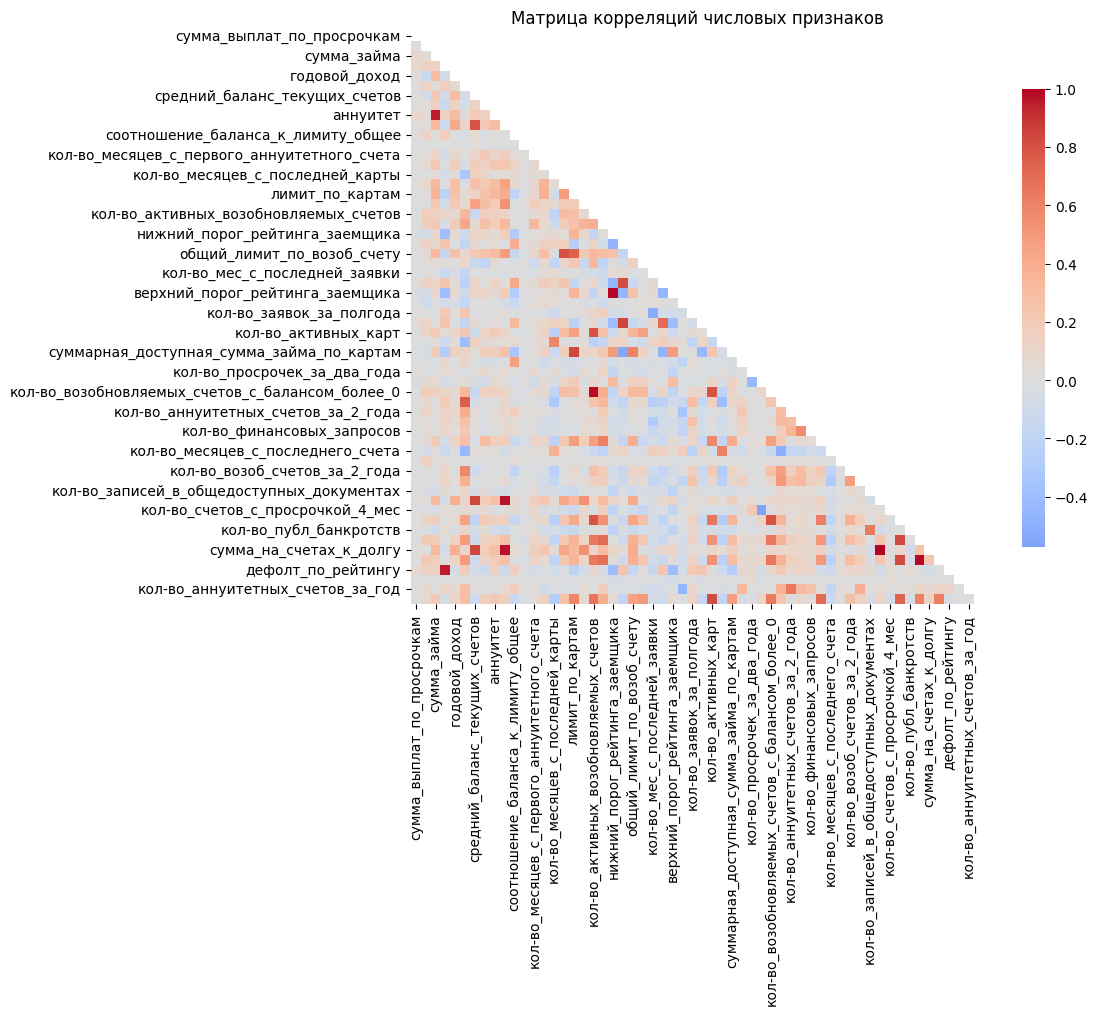


Найдено 8 пар признаков с корреляцией ≥ 0.95:
--------------------------------------------------------------------------------
общая_сумма_на_счетах ↔ сумма_на_счетах_к_долгу: r = 1.0000 (|r| = 1.0000)
нижний_порог_рейтинга_заемщика ↔ верхний_порог_рейтинга_заемщика: r = 1.0000 (|r| = 1.0000)
кол-во_открытых_счетов ↔ кол-во_счетов_без_нарушений: r = 0.9839 (|r| = 0.9839)
кол-во_активных_возобновляемых_счетов ↔ кол-во_возобновляемых_счетов_с_балансом_более_0: r = 0.9820 (|r| = 0.9820)
кредитный_лимит ↔ общая_сумма_на_счетах: r = 0.9754 (|r| = 0.9754)
кредитный_лимит ↔ сумма_на_счетах_к_долгу: r = 0.9754 (|r| = 0.9754)
сумма_займа ↔ аннуитет: r = 0.9533 (|r| = 0.9533)
процентная_ставка ↔ дефолт_по_рейтингу: r = 0.9517 (|r| = 0.9517)

Топ 10 пар признаков с highest корреляцией:
------------------------------------------------------------
 1. общая_сумма_на_счетах ↔ сумма_на_счетах_к_долгу: r = 1.0000
 2. нижний_порог_рейтинга_заемщика ↔ верхний_порог_рейтинга_заемщика: r = 1.0000
 3. кол

In [30]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler

def analyze_feature_correlations(X, selected_features=None, threshold=0.95, plot=True, figsize=(12, 10)):
    """
    Анализ корреляций между числовыми признаками

    Параметры:
    X: DataFrame - исходные данные
    selected_features: list, optional - список признаков для анализа (если None, используются все числовые)
    threshold: float - порог для определения сильной корреляции
    plot: bool - строить ли график
    figsize: tuple - размер графика

    Возвращает:
    high_corr_pairs: list - список пар признаков с высокой корреляцией
    corr_matrix: DataFrame - матрица корреляций
    """

    # Выбираем числовые признаки
    if selected_features:
        numeric_features = [col for col in selected_features if X[col].dtype in ['int64', 'float64']]
    else:
        numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

    print(f"Анализ корреляций для {len(numeric_features)} числовых признаков")

    # Создаем копию данных только с числовыми признаками
    X_numeric = X[numeric_features].copy()

    # Заполнение пропусков медианой (для корректного расчета корреляций)
    X_numeric = X_numeric.fillna(X_numeric.median())

    # Вычисление матрицы корреляций
    corr_matrix = X_numeric.corr()

    if plot:
        # Построение тепловой карты корреляций
        plt.figure(figsize=figsize)

        # Создаем маску для верхнего треугольника (чтобы не дублировать)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        # Тепловая карта
        sns.heatmap(corr_matrix,
                    mask=mask,
                    annot=False,  # Не аннотируем все значения для лучшей читаемости
                    cmap='coolwarm',
                    center=0,
                    square=True,
                    fmt='.2f',
                    cbar_kws={"shrink": .8})

        plt.title('Матрица корреляций числовых признаков')
        plt.tight_layout()
        plt.show()

    # Поиск признаков с высокой корреляцией
    # Создаем маску для верхнего треугольника (без диагонали)
    upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    # Находим пары с корреляцией выше порога
    high_corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = abs(corr_matrix.iloc[i, j])
            if corr_value >= threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j],
                    'abs_correlation': corr_value
                })

    # Сортировка по абсолютной корреляции
    high_corr_pairs.sort(key=lambda x: x['abs_correlation'], reverse=True)

    if high_corr_pairs:
        print(f"\nНайдено {len(high_corr_pairs)} пар признаков с корреляцией ≥ {threshold}:")
        print("-" * 80)
        for pair in high_corr_pairs:
            print(f"{pair['feature1']} ↔ {pair['feature2']}: "
                  f"r = {pair['correlation']:.4f} (|r| = {pair['abs_correlation']:.4f})")
    else:
        print(f"\nПар признаков с корреляцией ≥ {threshold} не найдено")

    return high_corr_pairs, corr_matrix

def find_correlated_features_to_remove(corr_matrix, threshold=0.95):
    """
    Определение признаков для удаления на основе высокой корреляции

    Параметры:
    corr_matrix: DataFrame - матрица корреляций
    threshold: float - порог корреляции

    Возвращает:
    features_to_remove: list - признаки, рекомендуемые к удалению
    """

    # Создаем маску для верхнего треугольника
    upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    # Находим признаки с высокой корреляцией
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    # Определяем признаки для удаления
    # Стратегия: удаляем второй признак в каждой паре
    features_to_remove = set()
    for feature1, feature2 in high_corr_pairs:
        features_to_remove.add(feature2)

    return list(features_to_remove)

def get_top_correlated_pairs(corr_matrix, top_n=20):
    """
    Получение топ N пар признаков с самой высокой корреляцией

    Параметры:
    corr_matrix: DataFrame - матрица корреляций
    top_n: int - количество пар для отображения

    Возвращает:
    top_pairs: list - топ пар признаков
    """

    # Создаем список всех пар (верхний треугольник без диагонали)
    pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j],
                'abs_correlation': abs(corr_matrix.iloc[i, j])
            })

    # Сортировка по абсолютной корреляции
    pairs.sort(key=lambda x: x['abs_correlation'], reverse=True)

    return pairs[:top_n]


# Анализ корреляций для всех числовых признаков
high_corr_pairs, corr_matrix = analyze_feature_correlations(X_train, threshold=0.95)

# Получение топ 10 самых коррелирующих пар
top_correlated = get_top_correlated_pairs(corr_matrix, top_n=10)
print("\nТоп 10 пар признаков с highest корреляцией:")
print("-" * 60)
for i, pair in enumerate(top_correlated, 1):
    print(f"{i:2d}. {pair['feature1']} ↔ {pair['feature2']}: "
          f"r = {pair['correlation']:.4f}")

# Определение признаков для удаления
features_to_remove = find_correlated_features_to_remove(corr_matrix, threshold=0.95)
print(f"\nПризнаки, рекомендуемые к удалению (корреляция ≥ 0.95): {features_to_remove}")

# Создание списка признаков для сохранения
all_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
features_to_keep = [f for f in all_features if f not in features_to_remove]
print(f"\nПризнаков оставлено: {len(features_to_keep)}")
print(f"Признаков удалено: {len(features_to_remove)}")

# # Расширенная функция для анализа корреляций с конкретными признаками
# def analyze_correlations_with_target(X, y, top_n=20):
#     """
#     Анализ корреляций признаков с целевой переменной

#     Параметры:
#     X: DataFrame - признаки
#     y: Series - целевая переменная
#     top_n: int - количество топ признаков

#     Возвращает:
#     target_correlations: DataFrame - корреляции с целевой переменной
#     """

#     # Выбираем числовые признаки
#     numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

#     # Создаем DataFrame с признаками и целевой переменной
#     df_combined = X[numeric_features].copy()
#     df_combined['target'] = y

#     # Заполнение пропусков
#     df_combined = df_combined.fillna(df_combined.median())

#     # Вычисление корреляций с целевой переменной
#     target_corr = df_combined.corr()['target'].drop('target').abs()

#     # Сортировка
#     target_correlations = target_corr.sort_values(ascending=False)

#     print(f"Топ {top_n} признаков по корреляции с целевой переменной:")
#     print("-" * 50)
#     for i, (feature, corr) in enumerate(target_correlations.head(top_n).items(), 1):
#         original_corr = df_combined[feature].corr(df_combined['target'])
#         print(f"{i:2d}. {feature}: {original_corr:.4f} (|r| = {corr:.4f})")

#     return target_correlations

# # Пример использования анализа с целевой переменной:
# """
# target_correlations = analyze_correlations_with_target(X_train, y_train, top_n=15)

# # Визуализация топ корреляций с целевой переменной
# plt.figure(figsize=(10, 8))
# top_features_target = target_correlations.head(15)
# plt.barh(range(len(top_features_target)), top_features_target.values)
# plt.yticks(range(len(top_features_target)), top_features_target.index)
# plt.xlabel('Абсолютная корреляция с целевой переменной')
# plt.title('Топ 15 признаков по корреляции с целевой переменной')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()
# """

In [32]:
X_train_cor = X_train_60_perc.drop(['общая_сумма_на_счетах', 'верхний_порог_рейтинга_заемщика', 'кол-во_активных_возобновляемых_счетов'], axis=1)

In [33]:
model_cb_60_perc_cor, auc_score_cb_60_perc_cor = train_catboost_model(X_train_cor, y_train)
print(f"AUC для CatBoost с топ 60 признаками: {auc_score_cb_60_perc_cor:.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7281304	best: 0.7281304 (0)	total: 199ms	remaining: 1m 39s
200:	test: 0.7599217	best: 0.7599217 (200)	total: 35.4s	remaining: 52.7s
400:	test: 0.7625794	best: 0.7625824 (393)	total: 1m 10s	remaining: 17.4s
499:	test: 0.7632905	best: 0.7632917 (498)	total: 1m 28s	remaining: 0us
bestTest = 0.7632917166
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7273466	best: 0.7273466 (0)	total: 184ms	remaining: 1m 31s
200:	test: 0.7577214	best: 0.7577214 (200)	total: 35.4s	remaining: 52.7s
400:	test: 0.7615224	best: 0.7615224 (400)	total: 1m 8s	remaining: 17s
499:	test: 0.7624223	best: 0.7624223 (499)	total: 1m 25s	remaining: 0us
bestTest = 0.7624222636
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7281980	best: 0.7281980 (0)	total: 208ms	remaining: 1m 43s
200:	test: 0.7596504	best: 0.7596504 (200)	total: 33.4s	remaining: 49.8s
400:	test: 0.7621971	best: 0.7621971 (400)	total: 1m 8s	remaining: 17s
499:	test: 0.7632248	best: 0.7632248 (499)	total: 1m 25s	remaining: 0us
bestTest = 0.7632248402
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7259166	best: 0.7259166 (0)	total: 203ms	remaining: 1m 41s
200:	test: 0.7597437	best: 0.7597437 (200)	total: 35.1s	remaining: 52.2s
400:	test: 0.7624633	best: 0.7624641 (399)	total: 1m 9s	remaining: 17s
499:	test: 0.7633207	best: 0.7633229 (498)	total: 1m 25s	remaining: 0us
bestTest = 0.7633228898
bestIteration = 498
Shrink model to first 499 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7265380	best: 0.7265380 (0)	total: 193ms	remaining: 1m 36s
200:	test: 0.7596272	best: 0.7596272 (200)	total: 33.1s	remaining: 49.3s
400:	test: 0.7625903	best: 0.7625903 (400)	total: 1m 8s	remaining: 16.8s
499:	test: 0.7634592	best: 0.7634592 (499)	total: 1m 24s	remaining: 0us
bestTest = 0.7634592056
bestIteration = 499
AUC для CatBoost с топ 60 признаками: 0.7631


удалить!

In [30]:
X_train['тип_предоставления_кредита'].unique()

array(['Наличные', 'Перевод'], dtype=object)

In [31]:
X_train['первоначальный_статус_займа'].unique()

array(['б', 'а'], dtype=object)

In [26]:
features_to_keep_3

['сумма_выплат_по_просрочкам',
 'допрейтинг',
 'срок_займа',
 'пдн',
 'сумма_займа',
 'годовой_доход',
 'профессия_заемщика',
 'процентная_ставка',
 'стаж',
 'кол-во_открытых_счетов_за_2_года',
 'рейтинг',
 'регион',
 'владение_жильем',
 'кол-во_месяцев_с_первого_возобновляемого_счета',
 'средний_баланс_текущих_счетов',
 'кол-во_месяцев_с_первого_аннуитетного_счета',
 'аннуитет',
 'кол-во_ипотек',
 'макс_баланс_по_возоб_счетам',
 'кредитный_лимит',
 'соотношение_баланса_к_лимиту_общее',
 'кол-во_месяцев_с_последней_карты',
 'цель_займа',
 'индекс_проживания',
 'оборотный_баланс',
 'кол-во_активных_возобновляемых_счетов',
 'лимит_по_картам',
 'кол-во_счетов',
 'дата_первого_займа',
 'соотношение_баланса_к_лимиту_по_картам',
 'нижний_порог_рейтинга_заемщика',
 'общий_лимит_по_возоб_счету',
 'верхний_порог_рейтинга_заемщика',
 'кол-во_мес_с_последней_заявки',
 'подтвержден_ли_доход',
 'доля_карт_без_нарушений',
 'суммарная_доступная_сумма_займа_по_картам',
 'процент_счетов_прев_75_лимита'

## Обучение модели и кросс-валидация

**Выбор модели:**

У нас есть 18 категориальных признаков. Обработка таких признаков требует особого подхода (например, One-Hot Encoding, Label Encoding). Многие алгоритмы (например, логистическая регрессия, SVM) не могут напрямую работать с текстовыми категориями.


**CatBoost** же разработан специально для эффективной и автоматической обработки категориальных данных. Его можно напрямую обучить на признаках типа object без необходимости предварительного ручного кодирования. Также он хорошо справляется с пропущенными значениями и не требует их обязательного заполнения средними/медианами.

Вывод: Наличие большого количества категориальных признаков (object) делает CatBoost идеальным кандидатом для этой задачи, обеспечивая при этом высокое качество, удобство использования и минимальную необходимость в ручной предобработке категорий.

На этом этапе мы обучаем модель **CatBoostClassifier** — используя 5-фолдную стратифицированную кросс-валидацию для надежной оценки качества

!!!!!!!!!!!! Попробовать заменять пропуски в категориальных признаках модой !!!!!!!!!!!

In [20]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
oof_preds = np.zeros(len(X_train))
cat_features = X_train.select_dtypes(include='object').columns.tolist()

# Заполняем пропуски в категориальных признаках
for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].fillna('nan').astype(str)

for train_idx, val_idx in kf.split(X_train, y_train):
    X_train, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=3.0,
        random_strength=0.1,
        eval_metric='AUC',
        early_stopping_rounds=50,
        verbose=200,
        random_state=42,
        cat_features=cat_features
        # task_type='GPU'
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    val_pred = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred

    models.append(model)

print(f"Validation OOF AUC: {roc_auc_score(y, oof_preds):.4f}")

CatBoostError: Invalid type for cat_feature[non-default value idx=38,feature_idx=7]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

После обучения модели мы можем проанализировать, насколько каждый признак **"важен"** для принятия решений моделью. Это позволяет понять, какие переменные наиболее влияют на предсказание риска дефолта

In [ ]:
# Получение важности признаков от модели CatBoost
importances = model.feature_importances_
feature_names = X.columns

# Создание DataFrame для удобного анализа
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)


Признаки с высокой важностью (топ 20)

In [ ]:
importance_df

,feature,importance
5,допрейтинг,13.276960
112,просрочка_к_доходу,7.624017
1,срок_займа,5.299700
37,сумма_выплат_по_просрочкам,3.828046
6,профессия_заемщика,3.489715
...,...,...
12,платежный_график,0.000000
36,непогашенная_сумма_из_тела_займов,0.000000
41,код_политики,0.000000
22,коэфф_невыплаченного_сумм_остатка,0.000000


Удаляем признаки с низкой важностью

In [ ]:
# threshold = 0.01 (0.7660)
# threshold = 0.05 (0.7662)
# threshold = 0.15 (0.7662)
threshold = 0.3
# threshold = 0.5

features_to_keep = importance_df[importance_df['importance'] >= threshold]['feature'].tolist()

In [ ]:
X = X[features_to_keep]

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
oof_preds = np.zeros(len(X))
cat_features = X.select_dtypes(include='object').columns.tolist()

# Заполняем пропуски в категориальных признаках
for col in cat_features:
    if col in X.columns:
        X[col] = X[col].fillna('nan').astype(str)

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=3.0,
        random_strength=0.1,
        eval_metric='AUC',
        early_stopping_rounds=50,
        verbose=200,
        random_state=42,
        cat_features=cat_features,
        task_type='GPU'
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    val_pred = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred

    models.append(model)

print(f"Validation OOF AUC: {roc_auc_score(y, oof_preds):.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7307394	best: 0.7307394 (0)	total: 345ms	remaining: 2m 52s
200:	test: 0.7608950	best: 0.7608950 (200)	total: 47s	remaining: 1m 9s
400:	test: 0.7643622	best: 0.7643622 (400)	total: 1m 32s	remaining: 22.8s
499:	test: 0.7649084	best: 0.7649084 (499)	total: 1m 56s	remaining: 0us
bestTest = 0.764908433
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7303998	best: 0.7303998 (0)	total: 374ms	remaining: 3m 6s
200:	test: 0.7606204	best: 0.7606204 (200)	total: 46.7s	remaining: 1m 9s
400:	test: 0.7642750	best: 0.7642750 (400)	total: 1m 32s	remaining: 22.8s
499:	test: 0.7653544	best: 0.7653544 (497)	total: 1m 55s	remaining: 0us
bestTest = 0.7653543949
bestIteration = 497
Shrink model to first 498 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7300300	best: 0.7300300 (0)	total: 209ms	remaining: 1m 44s
200:	test: 0.7634290	best: 0.7634290 (200)	total: 45.2s	remaining: 1m 7s
400:	test: 0.7665059	best: 0.7665059 (400)	total: 1m 30s	remaining: 22.3s
499:	test: 0.7670280	best: 0.7670280 (499)	total: 1m 53s	remaining: 0us
bestTest = 0.7670280337
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7288531	best: 0.7288531 (0)	total: 318ms	remaining: 2m 38s
200:	test: 0.7620229	best: 0.7620229 (200)	total: 46.7s	remaining: 1m 9s
400:	test: 0.7646940	best: 0.7646940 (400)	total: 1m 33s	remaining: 23.1s
499:	test: 0.7651141	best: 0.7651141 (499)	total: 1m 55s	remaining: 0us
bestTest = 0.7651140988
bestIteration = 499


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7257281	best: 0.7257281 (0)	total: 422ms	remaining: 3m 30s
200:	test: 0.7614709	best: 0.7614709 (200)	total: 46.1s	remaining: 1m 8s
400:	test: 0.7651346	best: 0.7651346 (400)	total: 1m 31s	remaining: 22.7s
499:	test: 0.7659290	best: 0.7659290 (499)	total: 1m 55s	remaining: 0us
bestTest = 0.7659290433
bestIteration = 499
Validation OOF AUC: 0.7657


In [ ]:
# 1. Выбираем только числовые признаки
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 2. Строим матрицу корреляций Пирсона
corr_matrix = X[num_features].corr().abs()

# 3. Создаем маску для верхнего треугольника матрицы (чтобы не дублировать пары)
#    np.ones_like создает массив единиц такой же формы, как corr_matrix
#    np.triu возвращает верхнюю треугольную часть массива (включая диагональ)
#    .astype(bool) преобразует в булевый массив
upper_triangle_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# 4. Применяем маску, чтобы получить только верхний треугольник
upper_triangle = corr_matrix.where(upper_triangle_mask)

# 5. Находим признаки с корреляцией больше порога
high_corr_pairs = upper_triangle > 0.95

# 6. Получаем список признаков для удаления
#    stack() преобразует DataFrame в Series с MultiIndex
#    loc[high_corr_pairs.stack()] отбирает только те пары, где корреляция > 0.95
#    index.droplevel(1).unique() получает уникальные имена признаков из первого уровня индекса
to_drop = high_corr_pairs.stack()[high_corr_pairs.stack()].index.droplevel(1).unique().tolist()

print(f"Признаки для удаления (корреляция > 0.95): {to_drop}")

# # 7. Удаляем признаки из данных
# X_reduced = X.drop(columns=to_drop)

# Также не забудьте удалить эти признаки из тестовой выборки
# X_test_reduced = X_test.drop(columns=to_drop)

# удалить займ_на_доход, нижний_порог_рейтинга, аннуитет, кол-во_возобновляемых_счетов_с_балансом_более_0

Признаки для удаления (корреляция > 0.95): ['займ_на_доход', 'верхний_порог_рейтинга_заемщика', 'сумма_займа', 'кол-во_активных_возобновляемых_счетов']


In [ ]:
corr_matrix['кол-во_активных_возобновляемых_счетов']

,кол-во_активных_возобновляемых_счетов
просрочка_к_доходу,0.003086
сумма_выплат_по_просрочкам,0.009547
пдн,0.190010
процентная_ставка,0.086646
кол-во_открытых_счетов_за_2_года,0.337524
баланс_к_аннуитету,0.200307
займ_на_доход,0.003648
кол-во_месяцев_с_первого_возобновляемого_счета,0.159334
платеж_на_доход,0.003287
годовой_доход,0.072719


In [ ]:
X_d = X.drop(['займ_на_доход', 'нижний_порог_рейтинга_заемщика', 'сумма_займа', 'кол-во_возобновляемых_счетов_с_балансом_более_0'], axis=1)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
oof_preds = np.zeros(len(X))
cat_features = X_d.select_dtypes(include='object').columns.tolist()

# Заполняем пропуски в категориальных признаках
for col in cat_features:
    if col in X_d.columns:
        X_d[col] = X_d[col].fillna('nan').astype(str)

for train_idx, val_idx in kf.split(X_d, y):
    X_train, X_val = X_d.iloc[train_idx], X_d.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=600,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=3.0,
        random_strength=0.1,
        eval_metric='AUC',
        early_stopping_rounds=50,
        verbose=200,
        random_state=42,
        cat_features=cat_features,
        task_type='GPU'
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    val_pred = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred

    models.append(model)

print(f"Validation OOF AUC: {roc_auc_score(y, oof_preds):.4f}")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7307336	best: 0.7307336 (0)	total: 416ms	remaining: 4m 9s
200:	test: 0.7603821	best: 0.7603821 (200)	total: 49s	remaining: 1m 37s
400:	test: 0.7649130	best: 0.7649159 (399)	total: 1m 37s	remaining: 48.4s
599:	test: 0.7657747	best: 0.7657843 (590)	total: 2m 27s	remaining: 0us
bestTest = 0.7657843232
bestIteration = 590
Shrink model to first 591 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7303998	best: 0.7303998 (0)	total: 363ms	remaining: 3m 37s
200:	test: 0.7611369	best: 0.7611369 (200)	total: 48.6s	remaining: 1m 36s
400:	test: 0.7652695	best: 0.7652738 (399)	total: 1m 36s	remaining: 48s
599:	test: 0.7665174	best: 0.7665174 (599)	total: 2m 24s	remaining: 0us
bestTest = 0.7665173709
bestIteration = 599


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7303323	best: 0.7303323 (0)	total: 250ms	remaining: 2m 30s
200:	test: 0.7635261	best: 0.7635261 (200)	total: 48.4s	remaining: 1m 36s
400:	test: 0.7665332	best: 0.7665332 (400)	total: 1m 37s	remaining: 48.4s
599:	test: 0.7680431	best: 0.7680431 (599)	total: 2m 26s	remaining: 0us
bestTest = 0.768043071
bestIteration = 599


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7288531	best: 0.7288531 (0)	total: 262ms	remaining: 2m 37s
200:	test: 0.7619585	best: 0.7619585 (200)	total: 47.9s	remaining: 1m 35s
400:	test: 0.7650737	best: 0.7650737 (400)	total: 1m 37s	remaining: 48.5s
599:	test: 0.7663580	best: 0.7663644 (591)	total: 2m 26s	remaining: 0us
bestTest = 0.7663643658
bestIteration = 591
Shrink model to first 592 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7290744	best: 0.7290744 (0)	total: 440ms	remaining: 4m 23s
200:	test: 0.7628448	best: 0.7628448 (200)	total: 48.4s	remaining: 1m 35s
400:	test: 0.7660215	best: 0.7660215 (400)	total: 1m 36s	remaining: 47.8s
599:	test: 0.7677265	best: 0.7677265 (599)	total: 2m 25s	remaining: 0us
bestTest = 0.7677265406
bestIteration = 599
Validation OOF AUC: 0.7669


## Оценка качества модели на тестовых данных

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

def evaluate_model_on_test(models, X_test, y_test):
    """
    Оценка ансамбля моделей CatBoost на тестовых данных

    Параметры:
    models: list - список обученных моделей CatBoost
    X_test: DataFrame - тестовые признаки
    y_test: Series - истинные значения целевой переменной

    Возвращает:
    predictions: array - предсказанные вероятности
    auc_score: float - AUC на тесте
    """

    # Подготовка тестовых данных
    X_test_processed = X_test.copy()

    # Обработка категориальных признаков (аналогично обучению)
    cat_features = X_test_processed.select_dtypes(include='object').columns.tolist()
    for col in cat_features:
        if col in X_test_processed.columns:
            X_test_processed[col] = X_test_processed[col].fillna('nan').astype(str)

    # Предсказания от каждой модели в ансамбле
    test_predictions = []

    for i, model in enumerate(models):
        # Предсказания вероятностей для класса 1
        fold_pred = model.predict_proba(X_test_processed)[:, 1]
        test_predictions.append(fold_pred)
        print(f"Модель {i+1}: средняя вероятность = {np.mean(fold_pred):.4f}")

    # Усреднение предсказаний всех моделей (ансамблевый подход)
    ensemble_predictions = np.mean(test_predictions, axis=0)

    # Расчет метрик
    test_auc = roc_auc_score(y_test, ensemble_predictions)

    print("="*50)
    print("РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ")
    print("="*50)
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Средняя вероятность: {np.mean(ensemble_predictions):.4f}")
    print(f"Стандартное отклонение: {np.std(ensemble_predictions):.4f}")

    # Дополнительные метрики (с порогом 0.5)
    y_pred_binary = (ensemble_predictions > 0.5).astype(int)

    print("\nКлассификационный отчет:")
    print(classification_report(y_test, y_pred_binary))

    return ensemble_predictions, test_auc

def plot_test_results(y_test, predictions, test_auc):
    """
    Визуализация результатов тестирования
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 1. ROC кривая
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, predictions)
    axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()
    axes[0].grid(True)

    # 2. Распределение предсказаний
    axes[1].hist(predictions[y_test == 0], bins=50, alpha=0.7, label='Class 0', density=True)
    axes[1].hist(predictions[y_test == 1], bins=50, alpha=0.7, label='Class 1', density=True)
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Distribution of Predictions')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def analyze_predictions(predictions, y_test):
    """
    Детальный анализ предсказаний
    """
    # Матрица ошибок
    y_pred_binary = (predictions > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Статистика по предсказаниям
    print("Статистика предсказаний:")
    print(f"- Минимальная вероятность: {np.min(predictions):.4f}")
    print(f"- Максимальная вероятность: {np.max(predictions):.4f}")
    print(f"- Медиана: {np.median(predictions):.4f}")

    print(f"\nДля класса 0 (не-дефолт):")
    print(f"- Средняя вероятность: {np.mean(predictions[y_test == 0]):.4f}")
    print(f"- Стандартное отклонение: {np.std(predictions[y_test == 0]):.4f}")

    print(f"\nДля класса 1 (дефолт):")
    print(f"- Средняя вероятность: {np.mean(predictions[y_test == 1]):.4f}")
    print(f"- Стандартное отклонение: {np.std(predictions[y_test == 1]):.4f}")

# Пример использования:
"""
# Предполагается, что у вас уже есть:
# models - обученные модели из train_catboost_model
# X_test - тестовые признаки
# y_test - истинные метки тестовой выборки

# Оценка модели
predictions, test_auc = evaluate_model_on_test(models, X_test, y_test)

# Визуализация результатов
plot_test_results(y_test, predictions, test_auc)

# Детальный анализ
analyze_predictions(predictions, y_test)
"""

# Если нужно сохранить предсказания для сабмита:
def save_predictions(predictions, test_ids=None, filename='predictions.csv'):
    """
    Сохранение предсказаний в файл

    Параметры:
    predictions: array - предсказанные вероятности
    test_ids: array - идентификаторы тестовых записей (опционально)
    filename: str - имя файла для сохранения
    """
    if test_ids is not None:
        submission = pd.DataFrame({
            'id': test_ids,
            'prediction': predictions
        })
    else:
        submission = pd.DataFrame({
            'prediction': predictions
        })

    submission.to_csv(filename, index=False)
    print(f"Предсказания сохранены в {filename}")

    return submission

## Сохранение обученной модели